In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:
actions = pd.read_csv("../../data/processed_balabit_data.csv")
actions.head()

,traveled_distance_pixel,elapsed_time,straightness,num_points,sum_of_angles,mean_curv,sd_curv,max_curv,min_curv,mean_omega,...,action_3,action_4,direction_1,direction_2,direction_3,direction_4,direction_5,direction_6,direction_7,user
0,2596.537181,9.329,0.198032,82,56.525861,-0.085272,0.527422,1.091459,-3.141593,15.669106,...,0,0,0,0,1,0,0,0,0,12
1,179.260212,1.919,0.959645,14,11.255258,-0.235679,0.916836,0.314159,-3.141593,-10.058717,...,0,1,0,1,0,0,0,0,0,12
2,887.903498,2.137,0.979540,21,-14.268377,-0.078308,0.112436,0.261799,-1.570796,-5.221251,...,0,0,0,0,0,0,0,0,1,12
3,75.035669,1.358,0.999613,7,-0.071307,-0.000650,0.002580,0.001828,-0.005080,0.052710,...,0,1,0,0,0,0,0,0,1,12
4,1078.673940,3.541,0.949591,27,-24.025555,-0.040986,0.174415,0.249828,-0.628390,4.743248,...,1,0,0,0,0,1,0,0,0,12


# Three users only

A multiclass K-Nearest Neighbors classification for three users.

Data processed.
PCA done on scaled data.
GridSearchCV used on unscaled data.
Predictions made on unscaled data.

## Processing

In [3]:
actions = actions[(actions["user"] == 7) | (actions["user"] == 9) | (actions["user"] == 29)]
actions.reset_index(drop=True, inplace=True)

In [4]:
X = actions.drop("user", axis=1)
y = actions["user"]

In [5]:
scaler = StandardScaler()

In [6]:
X_scale = scaler.fit_transform(X)

## PCA

In [7]:
pca = PCA(n_components=3)

In [8]:
pca.fit(X_scale)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [9]:
pca.explained_variance_ratio_

array([0.26835496, 0.12720416, 0.06112728])

In [10]:
X_reduced = pca.fit_transform(X_scale)

In [11]:
def biplot(score, coeff, labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())
    plt.figure(figsize=(16,8))
    plt.scatter(xs * scalex, ys * scaley, c = y)
    
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

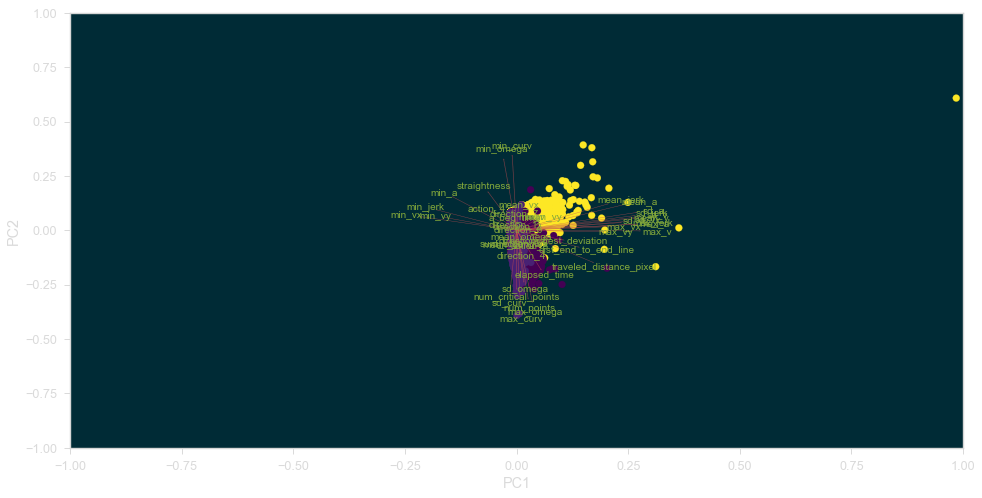

In [12]:
biplot(X_reduced[:,0:2], np.transpose(pca.components_[0:2, :]), labels=actions.columns)
plt.show()

In [13]:
n_pcs = pca.components_.shape[0]

In [14]:
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

In [15]:
initial_feature_names = list(range(47))

In [16]:
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

In [17]:
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

In [18]:
pca_df = pd.DataFrame(dic.items())

In [19]:
pca_df

,0,1
0,PC0,25
1,PC1,7
2,PC2,10


In [20]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reduced, y, test_size=0.3,
                                                            random_state=42)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## KNN GridSearch

In [22]:
param_grid = {"n_neighbors": np.arange(1, 200, 2),
              "weights":["uniform", "distance"]}

In [23]:
knn_gscv = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)

In [24]:
knn_gscv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': array([  1,   3,   5,   7,   9,  11,  13,  15,  17,  19,  21,  23,  25,
        27,  29,  31,  33,  35,  37,  39,  41,  43,  45,  47,  49,  51,
        53,  55,  57,  59,  61,  63,  65,  67...
        79,  81,  83,  85,  87,  89,  91,  93,  95,  97,  99, 101, 103,
       105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129,
       131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155,
       157, 159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181,
       183, 185, 187, 189, 191, 193, 195, 19

In [25]:
knn_gscv.best_params_

{'n_neighbors': 11, 'weights': 'distance'}

In [26]:
knn_gscv.best_score_

0.8612270265471011

## Prediction

In [27]:
pred_gscv = knn_gscv.predict(X_test)

In [28]:
print(classification_report(y_test, pred_gscv))
print(confusion_matrix(y_test, pred_gscv))

              precision    recall  f1-score   support

           7       0.83      0.82      0.83      1674
           9       0.73      0.74      0.74       964
          29       0.97      0.97      0.97      2189

    accuracy                           0.87      4827
   macro avg       0.84      0.85      0.85      4827
weighted avg       0.87      0.87      0.87      4827

[[1378  248   48]
 [ 230  717   17]
 [  54   12 2123]]


In [29]:
print("Accuracy: 87% of all the actions were classified correctly.")
print("Precision: 87% (FPR: 13%) of the actions predicted positive were truly positive.")
print("Recall: 87% of the actions predicted positive were correctly classified.")
print("F1-score: 0.87 Weighted average of precision and recall.")

Accuracy: 87% of all the actions were classified correctly.
Precision: 87% (FPR: 13%) of the actions predicted positive were truly positive.
Recall: 87% of the actions predicted positive were correctly classified.
F1-score: 0.87 Weighted average of precision and recall.
